In [1]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils

In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
imsize = 300  # desired size of the output image

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


style = image_loader("data/style/images/picasso.jpg").type(dtype)
content = image_loader("data/style/images/dancing.jpg").type(dtype)

/home/hemant/anaconda3/lib/python3.6/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU0 GeForce GTX 1060 with Max-Q Design which requires CUDA_VERSION >= 8000 for
     optimal performance and fast startup time, but your PyTorch was compiled
     with CUDA_VERSION 7050. Please install the correct PyTorch binary
     using instructions from http://pytorch.org
    
  warnings.warn(error_str % (d, name, 8000, CUDA_VERSION))


In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image


def imshow(tensor):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)


fig = plt.figure()

plt.subplot(221)
imshow(style.data)
plt.subplot(222)
imshow(content.data)

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion.forward(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [6]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [7]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram.forward(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion.forward(self.G, self.target)
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [8]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

In [9]:
# desired depth layers to compute style/content losses :
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# just in order to have an iterable access to or list of content/syle losses
content_losses = []
style_losses = []

model = nn.Sequential()  # the new Sequential module network
gram = GramMatrix()  # we need a gram module in order to compute style targets

# move these modules to the GPU if possible:
if use_cuda:
    model = model.cuda()
    gram = gram.cuda()

# weigth associated with content and style losses
content_weight = 1
style_weight = 1000

i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)  # ***

In [10]:
input = image_loader("data/style/images/dancing.jpg").type(dtype)
# if we want to fill it with a white noise:
# input.data = torch.randn(input.data.size()).type(dtype)

In [11]:
input = nn.Parameter(input.data)
optimizer = optim.LBFGS([input])

In [12]:
run = [0]
while run[0] <= 300:

    def closure():
        # correct the values of updated input image
        input.data.clamp_(0, 1)

        optimizer.zero_grad()
        model.forward(input)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.backward()
        for cl in content_losses:
            content_score += cl.backward()

        run[0]+=1
        if run[0] % 20 == 0:
            print("run " + str(run) + ":")
            print("Style Score",style_score.data[0])
            print("Content Score",content_score.data[0])

        return content_score+style_score

    optimizer.step(closure)

# a last correction...
input.data.clamp_(0, 1)

/home/hemant/anaconda3/lib/python3.6/site-packages/torch/autograd/__init__.py:93: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


run [20]:
Style Score 1.199528694152832
Content Score 0.5053161382675171
run [40]:
Style Score 0.44749122858047485
Content Score 0.5068288445472717
run [60]:
Style Score 0.1090926080942154
Content Score 0.44670867919921875
run [80]:
Style Score 0.08128548413515091
Content Score 0.39733797311782837
run [100]:
Style Score 0.07413546741008759
Content Score 0.3781569302082062
run [120]:
Style Score 0.06666716933250427
Content Score 0.370294451713562
run [140]:
Style Score 0.060261912643909454
Content Score 0.36542126536369324
run [160]:
Style Score 0.05664947256445885
Content Score 0.36162543296813965
run [180]:
Style Score 0.05452726408839226
Content Score 0.35872653126716614
run [200]:
Style Score 0.05321198329329491
Content Score 0.35607895255088806
run [220]:
Style Score 0.052331313490867615
Content Score 0.3545096814632416
run [240]:
Style Score 0.052406713366508484
Content Score 0.3525090515613556
run [260]:
Style Score 0.05172044038772583
Content Score 0.35160213708877563
run [280]:


( 0 , 0 ,.,.) = 
  0.0745  0.0827  0.0951  ...   0.0609  0.0147  0.0646
  0.0830  0.0716  0.2149  ...   0.0770  0.0664  0.0523
  0.1092  0.0885  0.1556  ...   0.0453  0.0631  0.0237
           ...             ⋱             ...          
  0.0000  0.0642  0.1046  ...   0.1686  0.2040  0.0000
  0.0491  0.1038  0.1914  ...   0.1963  0.2117  0.1080
  0.0000  0.0000  0.0000  ...   0.1154  0.2223  0.1328

( 0 , 1 ,.,.) = 
  0.2559  0.3020  0.1424  ...   0.1255  0.0957  0.1799
  0.2057  0.1462  0.1634  ...   0.1064  0.0859  0.1643
  0.2397  0.1520  0.1383  ...   0.0944  0.0914  0.2080
           ...             ⋱             ...          
  0.0500  0.2300  0.1775  ...   0.2215  0.2143  0.2703
  0.1089  0.1983  0.1330  ...   0.1972  0.1826  0.2881
  0.0000  0.1623  0.0964  ...   0.1768  0.1919  0.1825

( 0 , 2 ,.,.) = 
  0.2420  0.3149  0.2122  ...   0.1733  0.1666  0.1786
  0.1509  0.0961  0.2062  ...   0.0926  0.0795  0.1064
  0.1734  0.1311  0.2637  ...   0.1511  0.1082  0.1589
           

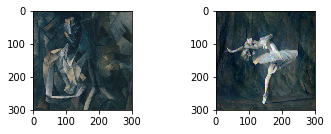

In [13]:
imshow(input.data)
plt.show()

In [14]:
utils.save_image(input.data,'data/style/images/generated.png')